In [1]:
import numpy as np 
import musclebeachtools as mbt
import os
import glob
import pandas as pd
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import seaborn as sns
from copy import deepcopy as cdc
import scipy.io as sio
import scipy
import datetime as dt
import plotly
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
import math
import sahara_work as saw
import sahara_work as sw
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.formula.api as smf
import neuraltoolkit as ntk
from scipy.stats import ks_2samp
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,v_measure_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import random
import scipy.cluster.hierarchy as spc


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})


from sys import platform
if platform == 'darwin':
    basedir = 'Volumes'
else:
    basedir = 'media'

from datetime import datetime

savedir = f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_1/'
today = datetime.today().strftime('%Y-%m-%d')

cmap = "YlGnBu"


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def kill3s(dat):
    # delete anything that's not single unit, and anything that isn't online for the entire recording.
    kills = np.zeros(1000)
    kills[kills == 0] = np.nan
    for j,k in enumerate(dat):
        if k.quality > 2 or k.presence_ratio()<1:
            kills[j] = j
    kills = np.delete(kills, np.isnan(kills))
    dat = np.delete(dat, kills.astype('int'))
    return dat

def corrloop(fn, bbin, window, step, t0=999, t1=999):
    '''
    CORRLOOP - Function to to count spikes in bin of BBIN and examine the Pearson correlation in WINDOW sized windows across a dataset that spans T0 to T1. 
    INPUT:
        FN: path to the file of interest
        T0: time to start corr analysis. Default of 999 is the beginning of the data
        T1: time to end corr analysis. Default of 999 is the end of the data
        BBIN: time bin (in seconds) in which spiking is binned for correlation
        WINDOW: time window (in minutes) across which bins are examined for corrrelation.
        STEP: time between t0 of window n and t0 of window n+1  
    
    RETURNS: 
        BINNEDSPIKES: A matrix of size neurons x  time steps/window x windows per dataset (e.g. 99 neurons, 18000 steps of 100 msec per half hour window, 96 steps of 5 minutes through 8h of recording)
        W_EDGES: The timestamps of the windows used to extract the spike count matrices
        ANIMAL: animal ID
        TAGE: age in seconds at the start of the block
    ''' 
    # Load the data
    dat = np.load(fn, allow_pickle=True)
    dat = kill3s(dat)

    # if t0 and t1 are 999, use the entire data
    if len(dat) < 2:
        print("""there are {} 1's/2's in this block""".format(len(dat)))
    if t0==999:
        t_on = dat[0].start_time
    if t1==999:
        t_off = dat[0].end_time

    w_edges = np.arange(t_on, t_off-(window*60) + (step*60), step*60, dtype="float64")
    
    # Preallocate a 3D array. Each row is a neuron, each column is a time step of bbin (e.g., 100 msec), then each slice (3rd dimension) is another window of WINDOW minutes. 
    nsteps = int((window*60)/bbin)
    binnedspikes = np.zeros([dat.size, nsteps-1, w_edges.size ])
    binnedspikes[binnedspikes==0] = np.nan

    # First, set up the larger windows that will move forward in steps of STEP
    for i, w in enumerate(w_edges):
        # Then, within the window, create edges of bbin to count spikes
        s_edges = np.linspace(w, (w+window*60)+bbin, nsteps, dtype="float64")
        for j, nrn in enumerate(dat):
            binnedspikes[j,:,i] = np.histogram(nrn.spike_time_sec, s_edges)[0]

    try:
        animal = dat[0].animal_name
    except:
        animal = thisanimal
    tage = sw.get_age_sec(dat[0].rstart_time, sw.get_birthday(animal))
    return binnedspikes, w_edges, animal, tage

from matplotlib.colors import LinearSegmentedColormap
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
blue_orange_divergent = LinearSegmentedColormap.from_list("custom_blue_orange", clist)

In [3]:
SAVEFIGS = 0

In [4]:
dfall_CV = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/dfall_CV.pkl')
dfall_CV['age_days'] = dfall_CV.cv_time/(24*3600)  

dfall_CV = dfall_CV.drop_duplicates(keep = 'last')

dfall_CV['bins'] = pd.cut(x=dfall_CV['age_days'], bins= [0,91,274,600],labels=['Young','Mid','Old'])


In [5]:
df_CV = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/kdr27_cv.pkl').reset_index()

list_age_days = []
for a in range(0,len(df_CV)):
    list_age_days.append(df_CV.iloc[a].cv_time/(3600*24))
    
df_CV['age_days'] = list_age_days
df_CV = df_CV.sort_values(by = 'age_days')

df_CV = df_CV[df_CV.cv_cellqual < 3]

cv_medians_wt = []
cv_sems_wt = []

for a in df_CV.age_days.unique():
    tempdf = df_CV[df_CV.age_days == a]
    cv_medians_wt.append(np.median(tempdf.cv))
    cv_sems_wt.append(np.std(tempdf.cv)/(len(tempdf.cv)**0.5))

cv_medians_wt = cv_medians_wt[0:84]
cv_sems_wt = cv_sems_wt[0:84]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


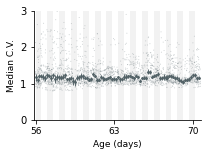

In [6]:
fig, ax = plt.subplots(figsize=[3,2])

#ax.scatter(np.arange(0,len(fr_means_wt)), fr_means_wt, color = sns.xkcd_rgb['gunmetal'], s=.2)
ax.errorbar(np.arange(0,len(cv_medians_wt)), cv_medians_wt, yerr=cv_sems_wt, fmt="o", ms=1.75, color = sns.xkcd_rgb['gunmetal'], linewidth=.9)

for g in np.arange(0,84,6):
    ax.add_patch(patches.Rectangle(
            (g, 0.00),
            3,
            3,
            edgecolor = 'none',
            facecolor = 'grey',
            fill=True,
        alpha = 0.1
         ) )

uniquedays = df_CV.age_days.unique()
testdf = df_CV[df_CV.age_days < uniquedays[83]+.00001]

for ss,tt in enumerate(uniquedays):
    testdf = testdf.replace(tt, ss)

sns.stripplot(data = testdf, x = 'age_days', y = 'cv', s=1, jitter = 1.1, color = sns.xkcd_rgb['gunmetal'], alpha=.3, ax = ax)

ax.set_xlabel('Age (days)', fontsize=9)
ax.set_ylabel('Median C.V.', fontsize=9)
ax.set_xticks([0,40,80],['56','63','70'], fontsize = 9)
ax.set_yticks([0,1,2,3],fontsize = 9)
ax.set_ylim([0, 3])
ax.set_xlim([-1, 84])
                  
#plt.title('KDR27, WT', fontsize = 12, color = sns.xkcd_rgb['gunmetal'])

sns.despine()

if SAVEFIGS == 1:
    fig.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_kdr27_median_CV.pdf')


In [7]:
df_CV2 = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/caf80_cv.pkl').reset_index()

list_age_days2 = []
for a in range(0,len(df_CV2)):
    list_age_days2.append(df_CV2.iloc[a].cv_time/(3600*24))
    
df_CV2['age_days'] = list_age_days2
df_CV2 = df_CV2.sort_values(by = 'age_days')

df_CV2 = df_CV2[df_CV2.cv_cellqual < 3]


time_offset = 12

cv_medians_te4 = []
cv_sems_te4 = []

for a in df_CV2.age_days.unique():
    tempdf = df_CV2[df_CV2.age_days == a]
    cv_medians_te4.append(np.median(tempdf.cv))
    cv_sems_te4.append(np.std(tempdf.cv)/(len(tempdf.cv)**0.5))

cv_medians_te4 = cv_medians_te4[0 + time_offset:84 + time_offset]
cv_sems_te4 = cv_sems_te4[0 + time_offset:84 + time_offset]
    


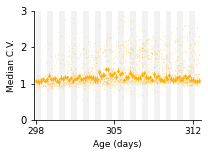

In [8]:
fig, ax = plt.subplots(figsize=[3,2])

ax.errorbar(np.arange(0,len(cv_medians_te4)), cv_medians_te4, yerr=cv_sems_te4, fmt="o", ms=1.75, color = sns.xkcd_rgb['saffron'], linewidth=.9)

for g in np.arange(0,84,6):
    ax.add_patch(patches.Rectangle(
            (g, 0.00),
            3,
            3,
            edgecolor = 'none',
            facecolor = 'grey',
            fill=True,
        alpha = 0.1
         ) )

uniquedays = df_CV2.age_days.unique()
testdf = df_CV2[df_CV2.age_days < uniquedays[83]+.00001]

for ss,tt in enumerate(uniquedays):
    testdf = testdf.replace(tt, ss)
    
sns.stripplot(data = testdf, x = 'age_days', y = 'cv', s=1, jitter = 1.1, color = sns.xkcd_rgb['saffron'], alpha=.3, ax = ax)

ax.set_xlabel('Age (days)', fontsize=9)
ax.set_ylabel('Median C.V.', fontsize=9)
ax.set_xticks([0,40,80],['298','305','312'], fontsize = 9)
ax.set_yticks([0,1,2,3],fontsize = 9)
ax.set_ylim([0, 3])
ax.set_xlim([-1, 84])
                                 
#plt.title('CAF84, TE4', fontsize = 12, color = sns.xkcd_rgb['saffron'])

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_caf84_median_CV.pdf')


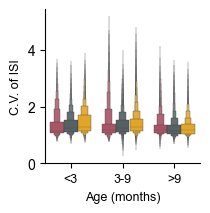

In [28]:
plt.figure(figsize=[2,2])
col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]

ax = sns.boxenplot(x = 'bins', y = 'cv', hue = 'cv_geno', showfliers=False, palette = col_palette, data=dfall_CV, linewidth = 0.25)

ax.set_xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
ax.set_xlabel('Age (months)', fontsize=9)
ax.set_yticks([0,2,4],fontsize=9)
ax.set_ylabel('C.V. of ISI', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_boxen_CVs.pdf')
    

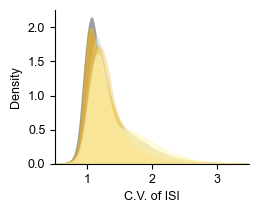

In [19]:
fig, ax = plt.subplots(figsize=[2.5,2])

# TE4 saffron fade: #fff8bd #fbd86e #feb209
# WT gunmetal fade: #cfdce1 #8f9da2 #536267

p =['wt', 'te4']
q = (['#cfdce1', '#8f9da2', '#536267'], ['#fff8bd', '#fbd86e', '#feb209'])
r = zip(p,q)

for gt in r:

    sns.kdeplot(
        data = dfall_CV[dfall_CV['cv_geno']==gt[0]], x='cv', hue='bins', fill=True, common_norm=False,
        palette= gt[1], alpha=.6, linewidth=0.1, log_scale = False, ax = ax
    )
    
ax.set_xlabel('C.V. of ISI',fontsize=9 )
ax.set_ylabel('Density', fontsize=9 )
ax.set_xlim([0.5,3.5])
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_CV_kde_1.pdf')

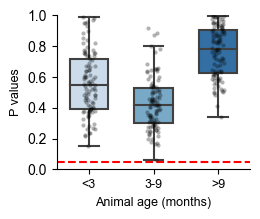

In [26]:
fig, ax = plt.subplots(figsize=[2.5, 2])

cv_young = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/cv_young.csv')
cv_mid = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/cv_mid.csv')
cv_old = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/cv_old.csv')

tempdf = pd.DataFrame()
ps = np.concatenate([np.array(cv_young.x), np.array(cv_mid.x), np.array(cv_old.x)])
xs = np.concatenate([np.ones(len(cv_young.x))*0, np.ones(len(cv_mid.x))*.5, np.ones(len(cv_old.x))*1])
data = {'Xvals': xs,
        'Data': ps}
tempdf = pd.DataFrame(data) 


sns.stripplot(data=tempdf, x="Xvals", y="Data", size=3, color = 'black', alpha=0.3)
sns.boxplot(data=tempdf, x="Xvals", y="Data", width = 0.6, palette = 'Blues', showfliers = False)

plt.hlines(0.05, -0.5, 2.5, linestyle='--', color='red')

plt.xticks(ticks= [0,1,2],labels=['<3','3-9','>9'], fontsize=9)
plt.yticks(ticks= np.arange(0,1.1,.2), fontsize=10)
plt.xlabel('Animal age (months)', fontsize=9)
plt.ylabel('P values', fontsize=9)
plt.xlim(-0.5,2.5)
plt.ylim(0, 1.0)

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_LME_CVs_pvals.pdf')
    
    

In [22]:
import numpy as np 
import musclebeachtools as mbt
import os
import glob
import pandas as pd
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import seaborn as sns
from copy import deepcopy as cdc
import scipy.io as sio
import scipy
import datetime as dt
import plotly
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
import math
import sahara_work as saw
#import statsmodels.api as sm
from statsmodels.formula.api import ols
from random import choices

#from bioinfokit.analys import stat
# from sklearn.linear_model import LinearRegression

bins = [0, 91, 274, 700]

wt_mean = []
wt_sem = []
te4_mean = []
te4_sem = []
e4_mean = []
e4_sem = []
num_wts = []
num_te4s = []
num_e4s = []

for h in np.arange(0,len(bins)-1):
    
    try:

        thisdf = []
        thisdf = dfall_CV[dfall_CV.age_days > bins[h]]
        thisdf = dfall_CV[dfall_CV.age_days < bins[h+1]]

        animal_array_temp = thisdf.cv_animal.unique()

        wt_temp = []
        te4_temp = []
        e4_temp = []

        for a in animal_array_temp:
            temparray = []
            temparray = thisdf[thisdf.cv_animal == a]

            if temparray.cv_geno.unique()[0] == 'wt':
                wt_temp.append(np.asarray(temparray.cv))
            elif temparray.cv_geno.unique()[0] == 'te4':
                te4_temp.append(np.asarray(temparray.cv))
            elif temparray.cv_geno.unique()[0] == 'e4':
                e4_temp.append(np.asarray(temparray.cv))


        num_wts.append(len(wt_temp))
        num_te4s.append(len(te4_temp))
        num_e4s.append(len(e4_temp))

        nboot = 10000 

        bootstrapping_matrix1 = np.zeros([nboot,1,len(wt_temp)])
        for a in np.arange(0,len(wt_temp)): #loop thru number of te4 animals
            temp = []
            temp = wt_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix1[n,0,a] = choices(temp, k=1)[0]

        bootstrapping_matrix2 = np.zeros([nboot,1,len(te4_temp)])
        for a in np.arange(0,len(te4_temp)): #loop thru number of te4 animals
            temp = []
            temp = te4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix2[n,0,a] = choices(temp, k=1)[0]


        bootstrapping_matrix3 = np.zeros([nboot,1,len(e4_temp)])
        for a in np.arange(0,len(e4_temp)): #loop thru number of e4 animals
            temp = []
            temp = e4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix3[n,0,a] = choices(temp, k=1)[0]


        nboot2 = 300 #Only repeating 300 times since the actual variance is in the previous step.
        bootstats1 = np.zeros([nboot2,1])
        bootstats2 = np.zeros([nboot2,1])
        bootstats3 = np.zeros([nboot2,1])

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(wt_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix1[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats1[n] = np.nanmean(tempdata)


        for n in np.arange(0,nboot2):
            temp_animals =[]
            temp_animals = choices(np.arange(0,len(te4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix2[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats2[n] = np.nanmean(tempdata)

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(e4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix3[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats3[n] = np.nanmean(tempdata)

        bootstats1 = bootstats1.flatten()
        bootstats2 = bootstats2.flatten()
        bootstats3 = bootstats3.flatten()

        wt_mean.append(np.nanmean(bootstats1))
        wt_sem.append(np.nanstd(bootstats1))
        te4_mean.append(np.nanmean(bootstats2))
        te4_sem.append(np.nanstd(bootstats2))
        e4_mean.append(np.nanmean(bootstats3))
        e4_sem.append(np.nanstd(bootstats3))

        sample1 = bootstats1
        sample2 = bootstats2

        joint_low_val = np.min([np.min(sample1), np.min(sample2)])
        joint_high_val = np.max([np.max(sample1), np.max(sample2)])

        p_joint_matrix = np.zeros([100,100])

        p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
        edge_shift = (p_axis[1] - p_axis[0])/2 
        p_axis_edges = p_axis - edge_shift
        p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

        def histc(X, bins):
            map_to_bins = np.digitize(X,bins)
            r = np.zeros(bins.shape)
            for i in map_to_bins:
                r[i-1] += 1
            return [r, map_to_bins]

        p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
        p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


        for i in np.arange(0, np.shape(p_joint_matrix)[0]):
            for j in np.arange(0,np.shape(p_joint_matrix)[1]):
                p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

        #p_joint_matrix
        p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
        p_test = sum(sum(np.triu(p_joint_matrix)));

        print(p_test)
        
    except:

        print(f'issue with loop number {h}')
        

0.5824888888888886
0.717988888888889
0.6439888888888889


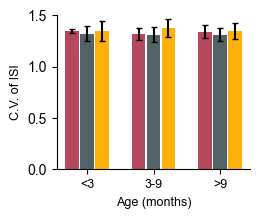

In [23]:
fig, ax = plt.subplots(1,figsize = (2.5,2))

color_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'],sns.xkcd_rgb['saffron']]

ax.bar([0,.9,1.8], [e4_mean[0], wt_mean[0], te4_mean[0]], yerr=[e4_sem[0], wt_sem[0], te4_sem[0]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.bar([4,4.9,5.8], [e4_mean[1], wt_mean[1], te4_mean[1]], yerr=[e4_sem[1], wt_sem[1], te4_sem[1]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.bar([8,8.9,9.8], [e4_mean[2], wt_mean[2], te4_mean[2]], yerr=[e4_sem[2], wt_sem[2], te4_sem[2]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.set_ylabel('C.V. of ISI', fontsize = 9)
ax.set_yticks([0.0, 0.5, 1.0, 1.5], fontsize = 9)
ax.set_ylim([0,1.5])
ax.set_xticks([.9,4.9,8.9],['<3','3-9','>9'], fontsize = 9)
ax.set_xlabel('Age (months)', fontsize = 9)

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_bootstapped_means_CV.pdf')

In [33]:
f = f'/{basedir}/HlabShare/Clustering_Data/KDR00014/12hr_bins/kdr14_10252021/0_12/probe1/co/H_2021-10-25_14-20-35_2021-10-26_02-15-37_neurons_group0.npy'

bbin = .1
window = 30
step = 5

binspikes, tstamps, animalid, t_age = corrloop(f, bbin, window, step)

# generate even intervals of time frames for plotting:
frames = np.round(np.linspace(0,binspikes.shape[2]-1,10))
frames = frames.astype('int')

gg = np.corrcoef(binspikes[:,:,np.min(frames)])
# get rid of autocorrelation of 1
gg[gg>=0.99] = 0
df = pd.DataFrame(gg)

binspikes2, tstamps2, animalid2, t_age2 = corrloop(f, bbin, window, step)
# generate even intervals of time frames for plotting:
frames2 = np.round(np.linspace(0,binspikes2.shape[2]-1,10))
frames2 = frames2.astype('int')
gg2 = np.corrcoef(binspikes2[:,:,np.max(frames2)])
gg2[gg2>=0.99] = 0
df2 = pd.DataFrame(gg2)


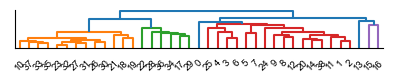

In [34]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig, ax = plt.subplots(1,1, figsize=(4.75, 0.5))

X = df.values
d = spc.distance.pdist(X) 
L = spc.linkage(d, method='complete')
ind = spc.fcluster(L, 0.5*d.max(), 'distance')

spc.dendrogram(L)
sns.despine()
plt.xticks(fontsize=7)
plt.yticks([])

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_young_wt_dendrogram.pdf')


/opt/anaconda3/envs/keither/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/keither/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


size of df2 is 39


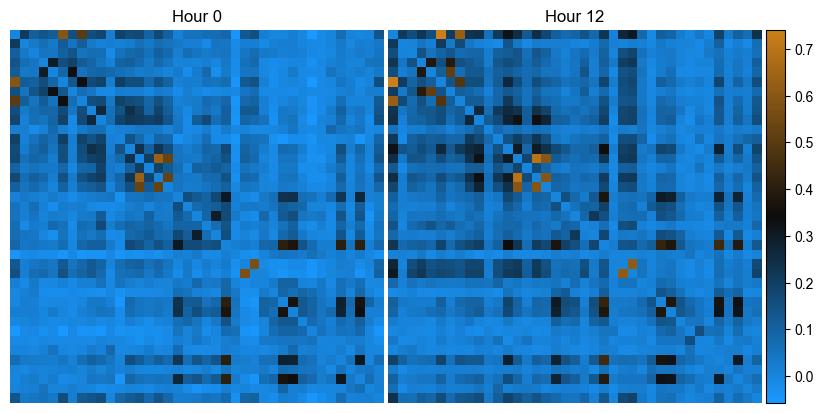

In [35]:
fig = plt.figure(figsize=(10,5))
grid = ImageGrid(fig, 111,
                nrows_ncols = (1,2),
                axes_pad = 0.05,
                cbar_location = "right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )

grid[0].imshow(df, cmap=blue_orange_divergent, vmin=np.min([np.min(df), np.min(df2)]), vmax=np.max([np.max(df), np.max(df2)]))
grid[0].axis('off')
grid[0].set_title('Hour 0')

imc = grid[1].imshow(df2, cmap=blue_orange_divergent, vmin=np.min([np.min(df), np.min(df2)]), vmax=np.max([np.max(df), np.max(df2)]))
grid[1].axis('off')
grid[1].set_title('Hour 12')

plt.colorbar(imc, cax=grid.cbar_axes[0])

print(f'size of df2 is {df2.shape[0]}')

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_young_wt_matrices.pdf')

In [37]:
f = f'/{basedir}/HlabShare/Clustering_Data/CAF00079/12hr_bins/caf79_02112021/12_24/probe1/co/H_2021-02-12_03-03-45_2021-02-12_14-58-45_neurons_group0.npy'

bbin = .1
window = 30
step = 5

binspikes, tstamps, animalid, t_age = corrloop(f, bbin, window, step)

# generate even intervals of time frames for plotting:
frames = np.round(np.linspace(0,binspikes.shape[2]-1,10))
frames = frames.astype('int')

gg = np.corrcoef(binspikes[:,:,np.min(frames)])
# get rid of autocorrelation of 1
gg[gg>=0.99] = 0
df = pd.DataFrame(gg)

binspikes2, tstamps2, animalid2, t_age2 = corrloop(f, bbin, window, step)
# generate even intervals of time frames for plotting:
frames2 = np.round(np.linspace(0,binspikes2.shape[2]-1,10))
frames2 = frames2.astype('int')
gg2 = np.corrcoef(binspikes2[:,:,np.max(frames2)])
gg2[gg2>=0.99] = 0
df2 = pd.DataFrame(gg2)


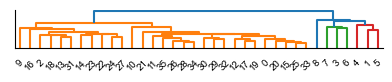

In [38]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig, ax = plt.subplots(1,1, figsize=(4.75, 0.5))

X = df.values
d = spc.distance.pdist(X) 
L = spc.linkage(d, method='complete')
ind = spc.fcluster(L, 0.5*d.max(), 'distance')

spc.dendrogram(L)
sns.despine()
plt.xticks(fontsize=7)
plt.yticks([])

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_old_te4_dendrogram.pdf')


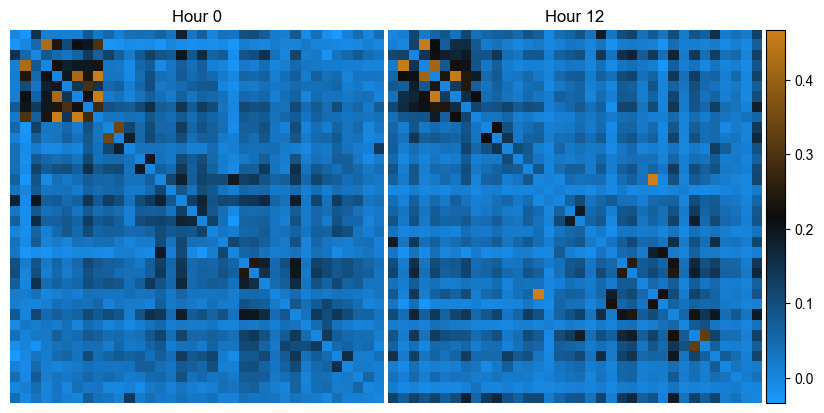

In [39]:
fig = plt.figure(figsize=(10,5))
grid = ImageGrid(fig, 111,
                nrows_ncols = (1,2),
                axes_pad = 0.05,
                cbar_location = "right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )

grid[0].imshow(df, cmap=blue_orange_divergent, vmin=np.min([np.min(df), np.min(df2)]), vmax=np.max([np.max(df), np.max(df2)]))
grid[0].axis('off')
grid[0].set_title('Hour 0')

imc = grid[1].imshow(df2, cmap=blue_orange_divergent, vmin=np.min([np.min(df), np.min(df2)]), vmax=np.max([np.max(df), np.max(df2)]))
grid[1].axis('off')
grid[1].set_title('Hour 12')

plt.colorbar(imc, cax=grid.cbar_axes[0])

#fig, ax = plt.subplots(1,2, figsize=(10, 5))
#gs = fig1.add_gridspec(1, 1)
#wax = fig1.add_subplot()
#cax = ax[0].matshow(df,cmap=blue_orange_divergent, vmin=np.min([np.min(df), np.min(df2)]), vmax=np.max([np.max(df), np.max(df2)]))
#plt.colorbar(cax)
#cax2 = ax[1].matshow(df2,cmap=blue_orange_divergent, vmin=np.min(np.min(df2)), vmax=np.max(np.max(df2)))


if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_old_te4_matrices.pdf')
    


In [3]:
mean_correlation_df = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/mean_correlation.pkl')
mean_correlation_df['L1_distance'] = np.array(mean_correlation_df['L1_distance']).astype(float)
bins = [0,91,274,600]
mean_correlation_df['bin'] = pd.cut(mean_correlation_df['age'], bins)



In [10]:
mean_correlation_df_combined

,age,mean_correlation,entropy,L1_distance,animal,genotype,bin,age_group
1503,89.574225,0.114394,3.718793,3.889934,caf49,te4,"(0, 91]",young
18281,168.693947,0.155489,3.829301,2.146083,caf49,te4,"(91, 274]",mid
18280,168.690475,0.160414,3.830921,2.632675,caf49,te4,"(91, 274]",mid
18279,168.687002,0.164102,3.828009,3.667283,caf49,te4,"(91, 274]",mid
18278,168.683530,0.168324,3.839437,3.285069,caf49,te4,"(91, 274]",mid
...,...,...,...,...,...,...,...,...
613,209.608067,0.073316,3.103424,0.929871,caf42,wt,"(91, 274]",mid
612,209.604595,0.069091,3.054597,0.790579,caf42,wt,"(91, 274]",mid
611,209.601123,0.073197,3.126153,0.801945,caf42,wt,"(91, 274]",mid
624,209.646262,0.073617,3.099850,0.917309,caf42,wt,"(91, 274]",mid


In [15]:
print(len(mean_correlation_df_combined[(mean_correlation_df_combined.genotype == 'wt')]))
print(len(mean_correlation_df_combined[(mean_correlation_df_combined.genotype == 'te4')]))

print(93617 + 104593)


93617
104593
198210


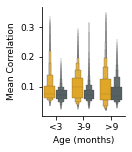

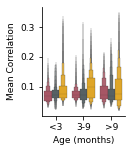

In [8]:
plt.figure(figsize=[1.5,2])

mean_correlation_df_combined = mean_correlation_df
mean_correlation_df_combined = mean_correlation_df_combined.replace('e4', 'wt')
mean_correlation_df_combined = mean_correlation_df_combined.sort_values(by='genotype')

# Define a function to categorize age
def categorize_age(age):
    if age < 91:
        return 'young'
    elif 91 <= age <= 274:
        return 'mid'
    else:
        return 'old'

# Apply the function to the age column to create the age_group column
mean_correlation_df_combined['age_group'] = mean_correlation_df_combined['age'].apply(categorize_age)


col_palette = [sns.xkcd_rgb['saffron'], sns.xkcd_rgb['gunmetal']]

ax = sns.boxenplot(x = 'bin', y = 'mean_correlation', hue = 'genotype', showfliers=False, palette = col_palette, data=mean_correlation_df_combined, linewidth = 0.25)

plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
plt.xlabel('Age (months)', fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Mean Correlation', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig3.5_figures/{today}_boxen_mean_correlation_grouped_wtande4.pdf')
    

plt.figure(figsize=[1.5,2])
col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]

ax = sns.boxenplot(x = 'bin', y = 'mean_correlation', hue = 'genotype', showfliers=False, palette = col_palette, data=mean_correlation_df, linewidth = 0.25)

plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
plt.xlabel('Age (months)', fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Mean Correlation', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig3.5_figures/{today}_boxen_mean_correlation.pdf')
    
    
    

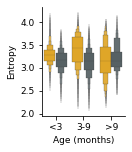

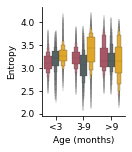

In [13]:
plt.figure(figsize=[1.5,2])

mean_correlation_df_combined = mean_correlation_df
mean_correlation_df_combined = mean_correlation_df_combined.replace('e4', 'wt')
mean_correlation_df_combined = mean_correlation_df_combined.sort_values(by='genotype')

col_palette = [sns.xkcd_rgb['saffron'], sns.xkcd_rgb['gunmetal']]

ax = sns.boxenplot(x = 'bin', y = 'entropy', hue = 'genotype', showfliers=False, palette = col_palette, data=mean_correlation_df_combined, linewidth = 0.25)

plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
plt.xlabel('Age (months)', fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Entropy', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig3.5_figures/{today}_boxen_entropy_grouped_wtande4.pdf')


plt.figure(figsize=[1.5,2])
col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]

ax = sns.boxenplot(x = 'bin', y = 'entropy', hue = 'genotype', showfliers=False, palette = col_palette, data=mean_correlation_df, linewidth = 0.25)

plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
plt.xlabel('Age (months)', fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Entropy', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_boxen_entropy.pdf')
    
    
    

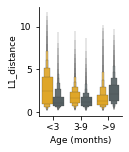

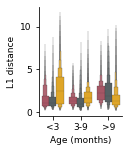

In [14]:
plt.figure(figsize=[1.5,2])

mean_correlation_df_combined = mean_correlation_df
mean_correlation_df_combined = mean_correlation_df_combined.replace('e4', 'wt')
mean_correlation_df_combined = mean_correlation_df_combined.sort_values(by='genotype')

col_palette = [sns.xkcd_rgb['saffron'], sns.xkcd_rgb['gunmetal']]

ax = sns.boxenplot(x = 'bin', y = 'L1_distance', hue = 'genotype', showfliers=False, palette = col_palette, data=mean_correlation_df_combined, linewidth = 0.25)

plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
plt.xlabel('Age (months)', fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('L1_distance', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig3.5_figures/{today}_boxen_L1_distance_grouped_wtande4.pdf')


plt.figure(figsize=[1.5,2])
col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]

ax = sns.boxenplot(x = 'bin', y = 'L1_distance', hue = 'genotype', showfliers=False, palette = col_palette, data=mean_correlation_df, linewidth = 0.25)

plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
plt.xlabel('Age (months)', fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('L1 distance', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_boxen_L1distance.pdf')
    
    
    

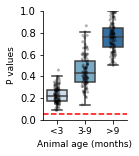

In [15]:
fig, ax = plt.subplots(figsize=[1.5, 2])

corr_young = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_meancorrelation_young.csv')
corr_mid = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_meancorrelation_mid.csv')
corr_old = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_meancorrelation_old.csv')

tempdf = pd.DataFrame()
ps = np.concatenate([np.array(corr_young.x), np.array(corr_mid.x), np.array(corr_old.x)])
xs = np.concatenate([np.ones(len(corr_young.x))*0, np.ones(len(corr_mid.x))*.5, np.ones(len(corr_old.x))*1])
data = {'Xvals': xs,
        'Data': ps}
tempdf = pd.DataFrame(data) 


sns.stripplot(data=tempdf, x="Xvals", y="Data", size=3, color = 'black', alpha=0.3)
sns.boxplot(data=tempdf, x="Xvals", y="Data", width = 0.7, palette = 'Blues', showfliers = False)

plt.hlines(0.05, -0.5, 2.5, linestyle='--', color='red')

plt.xticks(ticks= [0,1,2],labels=['<3','3-9','>9'], fontsize=9)
plt.yticks(ticks= np.arange(0,1.1,.2), fontsize=10)
plt.xlabel('Animal age (months)', fontsize=9)
plt.ylabel('P values', fontsize=9)
plt.xlim(-0.5,2.5)
plt.ylim(0, 1.0)

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_LME_MeanCorrelations_pvals.pdf')
    
    

In [56]:
print(len(np.where(corr_young < .05)[0]))
print(len(np.where(corr_mid < .05)[0]))
print(len(np.where(corr_old < .05)[0]))

0
0
0


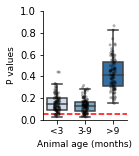

In [16]:
fig, ax = plt.subplots(figsize=[1.5, 2])

entropy_young = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_entropy_young.csv')
entropy_mid = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_entropy_mid.csv')
entropy_old = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_entropy_old.csv')

tempdf = pd.DataFrame()
ps = np.concatenate([np.array(entropy_young.x), np.array(entropy_mid.x), np.array(entropy_old.x)])
xs = np.concatenate([np.ones(len(entropy_young.x))*0, np.ones(len(entropy_mid.x))*.5, np.ones(len(entropy_old.x))*1])
data = {'Xvals': xs,
        'Data': ps}
tempdf = pd.DataFrame(data) 


sns.stripplot(data=tempdf, x="Xvals", y="Data", size=3, color = 'black', alpha=0.3)
sns.boxplot(data=tempdf, x="Xvals", y="Data", width = 0.7, palette = 'Blues', showfliers = False)

plt.hlines(0.05, -0.5, 2.5, linestyle='--', color='red')

plt.xticks(ticks= [0,1,2],labels=['<3','3-9','>9'], fontsize=9)
plt.yticks(ticks= np.arange(0,1.1,.2), fontsize=10)
plt.xlabel('Animal age (months)', fontsize=9)
plt.ylabel('P values', fontsize=9)
plt.xlim(-0.5,2.5)
plt.ylim(0, 1.0)

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_LME_Entropy_pvals.pdf')
    
    

In [55]:
print(len(np.where(entropy_young < .05)[0]))
print(len(np.where(entropy_mid < .05)[0]))
print(len(np.where(entropy_old < .05)[0]))

6
8
0


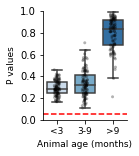

In [17]:
fig, ax = plt.subplots(figsize=[1.5, 2])

L1_young = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/LMER_loop_L1_distance_young.csv')
L1_mid = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/LMER_loop_L1_distance_mid.csv')
L1_old = pd.read_csv(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/LMER_loop_L1_distance_old.csv')

tempdf = pd.DataFrame()
ps = np.concatenate([np.array(L1_young.x), np.array(L1_mid.x), np.array(L1_old.x)])
xs = np.concatenate([np.ones(len(L1_young.x))*0, np.ones(len(L1_mid.x))*.5, np.ones(len(L1_old.x))*1])
data = {'Xvals': xs,
        'Data': ps}
tempdf = pd.DataFrame(data) 


sns.stripplot(data=tempdf, x="Xvals", y="Data", size=3, color = 'black', alpha=0.3)
sns.boxplot(data=tempdf, x="Xvals", y="Data", width = 0.7, palette = 'Blues', showfliers = False)

plt.hlines(0.05, -0.5, 2.5, linestyle='--', color='red')

plt.xticks(ticks= [0,1,2],labels=['<3','3-9','>9'], fontsize=9)
plt.yticks(ticks= np.arange(0,1.1,.2), fontsize=10)
plt.xlabel('Animal age (months)', fontsize=9)
plt.ylabel('P values', fontsize=9)
plt.xlim(-0.5,2.5)
plt.ylim(0, 1.0)

sns.despine()

if SAVEFIGS == 1:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_2/{today}_LME_L1_pvals.pdf')
    
    

In [18]:
mean_correlation_df_combined

,age,mean_correlation,entropy,L1_distance,animal,genotype,bin
1503,89.574225,0.114394,3.718793,3.889934,caf49,te4,"(0, 91]"
18281,168.693947,0.155489,3.829301,2.146083,caf49,te4,"(91, 274]"
18280,168.690475,0.160414,3.830921,2.632675,caf49,te4,"(91, 274]"
18279,168.687002,0.164102,3.828009,3.667283,caf49,te4,"(91, 274]"
18278,168.683530,0.168324,3.839437,3.285069,caf49,te4,"(91, 274]"
...,...,...,...,...,...,...,...
613,209.608067,0.073316,3.103424,0.929871,caf42,wt,"(91, 274]"
612,209.604595,0.069091,3.054597,0.790579,caf42,wt,"(91, 274]"
611,209.601123,0.073197,3.126153,0.801945,caf42,wt,"(91, 274]"
624,209.646262,0.073617,3.099850,0.917309,caf42,wt,"(91, 274]"


# LMER for mean correlation:

In [19]:
# Define a function to categorize age
def categorize_age(age):
    if age < 91:
        return 'young'
    elif 91 <= age <= 274:
        return 'mid'
    else:
        return 'old'

# Apply the function to the age column to create the age_group column
mean_correlation_df_combined['age_group'] = mean_correlation_df_combined['age'].apply(categorize_age)



In [18]:
mean_correlation_df_combined.to_csv(f'/media/HlabShare/te4_manuscript_james/manuscript_folders/{today}_meancorrelation_grouped_e4_wt.csv')




In [7]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface

In [8]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-14_meancorrelation_grouped_e4_wt.csv'
corr_data <- read_csv(file = fn)

#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
corr_lmer = lmer(mean_correlation ~ age_group * genotype  + (1|animal), data = corr_data)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
New names:
• `` -> `...1`
Rows: 198210 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): animal, genotype, bin, age_group
dbl (5): ...1, age, mean_correlation, entropy, L1_distance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [9]:
%%R 
# this will provide general information
summary(corr_lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: mean_correlation ~ age_group * genotype + (1 | animal)
   Data: corr_data

REML criterion at convergence: -866966

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8484 -0.5743 -0.1171  0.4375 10.8452 

Random effects:
 Groups   Name        Variance  Std.Dev.
 animal   (Intercept) 0.0010737 0.03277 
 Residual             0.0007365 0.02714 
Number of obs: 198210, groups:  animal, 36

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                1.020e-01  9.465e-03  3.306e+01  10.774 2.37e-12 ***
age_groupold              -2.449e-02  7.871e-04  1.958e+05 -31.122  < 2e-16 ***
age_groupyoung            -1.822e-04  2.924e-04  1.982e+05  -0.623    0.533    
genotypewt                -9.332e-03  1.252e-02  3.306e+01  -0.745    0.461    
age_groupold:genotypewt    1.410e-02  1.422e-02  3.321e+01   0.992    0.329    
age_groupy

In [10]:
%%R
# This will give us feedback about whether the main effects are significant 
anova(corr_lmer)

Type III Analysis of Variance Table with Satterthwaite's method
                    Sum Sq Mean Sq NumDF  DenDF  F value Pr(>F)    
age_group          1.19168 0.59584     2 64.400 809.0681 <2e-16 ***
genotype           0.00093 0.00093     1 32.995   1.2596 0.2698    
age_group:genotype 1.15676 0.57838     2 64.400 785.3610 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [11]:
%%R
emmresults = emmeans(corr_lmer, pairwise ~  age_group * genotype, adjust = 'tukey')
print(emmresults)

$emmeans
 age_group genotype emmean      SE  df asymp.LCL asymp.UCL
 mid       te4      0.1020 0.00947 Inf    0.0834    0.1205
 old       te4      0.0775 0.00947 Inf    0.0589    0.0961
 young     te4      0.1018 0.00947 Inf    0.0832    0.1204
 mid       wt       0.0927 0.00820 Inf    0.0766    0.1087
 old       wt       0.0823 0.01159 Inf    0.0595    0.1050
 young     wt       0.0674 0.00820 Inf    0.0513    0.0834

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$contrasts
 contrast              estimate       SE  df z.ratio p.value
 mid te4 - old te4     0.024495 0.000787 Inf  31.122  <.0001
 mid te4 - young te4   0.000182 0.000292 Inf   0.623  0.9894
 mid te4 - mid wt      0.009332 0.012522 Inf   0.745  0.9762
 mid te4 - old wt      0.019730 0.014962 Inf   1.319  0.7748
 mid te4 - young wt    0.034629 0.012525 Inf   2.765  0.0633
 old te4 - young te4  -0.024313 0.000840 Inf -28.959  <.0001
 old te4 - mid wt     -0.015163 0.012527 Inf  -1.210  0.8320
 old te4 

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 198210' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 198210' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.


# LMER for entropy:

In [25]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-14_meancorrelation_grouped_e4_wt.csv'
corr_data <- read_csv(file = fn)

#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
entr_lmer = lmer(entropy ~ age_group * genotype  + (1|animal), data = corr_data)


New names:
• `` -> `...1`
Rows: 198210 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): animal, genotype, bin, age_group
dbl (5): ...1, age, mean_correlation, entropy, L1_distance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
%%R 
# this will provide general information
summary(entr_lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: entropy ~ age_group * genotype + (1 | animal)
   Data: corr_data

REML criterion at convergence: -37693.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3339 -0.5849  0.0302  0.6135  5.2083 

Random effects:
 Groups   Name        Variance Std.Dev.
 animal   (Intercept) 0.06252  0.2500  
 Residual             0.04833  0.2198  
Number of obs: 198210, groups:  animal, 36

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                3.320e+00  7.224e-02  3.304e+01  45.961  < 2e-16 ***
age_groupold              -2.886e-01  6.375e-03  1.951e+05 -45.275  < 2e-16 ***
age_groupyoung             8.234e-03  2.369e-03  1.982e+05   3.476 0.000508 ***
genotypewt                -1.156e-01  9.556e-02  3.304e+01  -1.210 0.234832    
age_groupold:genotypewt    2.876e-01  1.085e-01  3.323e+01   2.651 0.012200 *  
age_groupyoung:genoty

In [27]:
%%R
# This will give us feedback about whether the main effects are significant 
anova(entr_lmer)

Type III Analysis of Variance Table with Satterthwaite's method
                   Sum Sq Mean Sq NumDF  DenDF  F value Pr(>F)    
age_group          52.653  26.327     2 64.443 544.7347 <2e-16 ***
genotype            0.041   0.041     1 32.971   0.8524 0.3626    
age_group:genotype 63.590  31.795     2 64.443 657.8856 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [28]:
%%R
emmresults = emmeans(entr_lmer, pairwise ~  age_group * genotype, adjust = 'tukey')
print(emmresults)

$emmeans
 age_group genotype emmean     SE  df asymp.LCL asymp.UCL
 mid       te4        3.32 0.0722 Inf      3.18      3.46
 old       te4        3.03 0.0723 Inf      2.89      3.17
 young     te4        3.33 0.0723 Inf      3.19      3.47
 mid       wt         3.20 0.0626 Inf      3.08      3.33
 old       wt         3.20 0.0884 Inf      3.03      3.38
 young     wt         3.03 0.0626 Inf      2.90      3.15

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$contrasts
 contrast              estimate      SE  df z.ratio p.value
 mid te4 - old te4     0.288641 0.00638 Inf  45.275  <.0001
 mid te4 - young te4  -0.008234 0.00237 Inf  -3.476  0.0067
 mid te4 - mid wt      0.115637 0.09556 Inf   1.210  0.8322
 mid te4 - old wt      0.116636 0.11418 Inf   1.022  0.9109
 mid te4 - young wt    0.293040 0.09559 Inf   3.066  0.0264
 old te4 - young te4  -0.296875 0.00680 Inf -43.654  <.0001
 old te4 - mid wt     -0.173004 0.09560 Inf  -1.810  0.4594
 old te4 - old wt     -0

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 198210' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 198210' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.


# LMER for L1 distance:

In [32]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-14_meancorrelation_grouped_e4_wt.csv'
corr_data <- read_csv(file = fn)

#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
L1_lmer = lmer(L1_distance ~ age_group * genotype  + (1|animal), data = corr_data)


New names:
• `` -> `...1`
Rows: 198210 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): animal, genotype, bin, age_group
dbl (5): ...1, age, mean_correlation, entropy, L1_distance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [33]:
%%R 
# this will provide general information
summary(L1_lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: L1_distance ~ age_group * genotype + (1 | animal)
   Data: corr_data

REML criterion at convergence: 513764.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7473 -0.5734 -0.1257  0.4143 11.7317 

Random effects:
 Groups   Name        Variance Std.Dev.
 animal   (Intercept) 1.0867   1.0424  
 Residual             0.7808   0.8836  
Number of obs: 198210, groups:  animal, 36

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                2.218e+00  3.011e-01  3.304e+01   7.365 1.84e-08 ***
age_groupold              -9.695e-01  2.563e-02  1.956e+05 -37.833  < 2e-16 ***
age_groupyoung             6.913e-01  9.520e-03  1.982e+05  72.617  < 2e-16 ***
genotypewt                -1.549e+00  3.984e-01  3.304e+01  -3.889  0.00046 ***
age_groupold:genotypewt    2.311e+00  4.523e-01  3.321e+01   5.110 1.31e-05 ***
age_groupyoung:ge

In [34]:
%%R
# This will give us feedback about whether the main effects are significant 
anova(L1_lmer)

Type III Analysis of Variance Table with Satterthwaite's method
                    Sum Sq Mean Sq NumDF  DenDF   F value Pr(>F)    
age_group          10869.8  5434.9     2 64.403 6960.8115 <2e-16 ***
genotype               1.1     1.1     1 32.975    1.3454 0.2544    
age_group:genotype  2048.3  1024.2     2 64.403 1311.7054 <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [35]:
%%R
emmresults = emmeans(L1_lmer, pairwise ~  age_group * genotype, adjust = 'tukey')
print(emmresults)

$emmeans
 age_group genotype emmean    SE  df asymp.LCL asymp.UCL
 mid       te4       2.218 0.301 Inf     1.628      2.81
 old       te4       1.248 0.301 Inf     0.658      1.84
 young     te4       2.909 0.301 Inf     2.319      3.50
 mid       wt        0.669 0.261 Inf     0.158      1.18
 old       wt        2.010 0.369 Inf     1.288      2.73
 young     wt        2.414 0.261 Inf     1.902      2.93

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$contrasts
 contrast             estimate      SE  df z.ratio p.value
 mid te4 - old te4       0.970 0.02563 Inf  37.833  <.0001
 mid te4 - young te4    -0.691 0.00952 Inf -72.617  <.0001
 mid te4 - mid wt        1.549 0.39838 Inf   3.889  0.0014
 mid te4 - old wt        0.207 0.47599 Inf   0.436  0.9980
 mid te4 - young wt     -0.196 0.39849 Inf  -0.491  0.9965
 old te4 - young te4    -1.661 0.02734 Inf -60.757  <.0001
 old te4 - mid wt        0.580 0.39853 Inf   1.454  0.6934
 old te4 - old wt       -0.762 0.47612 

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 198210' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 198210' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.


In [27]:
print(mean_correlation_df_combined[(mean_correlation_df_combined.age_group == 'young') 
                             & (mean_correlation_df_combined.genotype == 'te4')].mean_correlation.mean())

print(mean_correlation_df_combined[(mean_correlation_df_combined.age_group == 'mid') 
                             & (mean_correlation_df_combined.genotype == 'te4')].mean_correlation.mean())

print(mean_correlation_df_combined[(mean_correlation_df_combined.age_group == 'old') 
                             & (mean_correlation_df_combined.genotype == 'te4')].mean_correlation.mean())





0.09129460941436938
0.10216900427146253
0.0939112228310157


# Hierarchical bootstrap test for mean correlation and entropy:

In [24]:
mean_correlation_df_combined

,age,mean_correlation,entropy,L1_distance,animal,genotype,bin,age_group
1503,89.574225,0.114394,3.718793,3.889934,caf49,te4,"(0, 91]",young
18281,168.693947,0.155489,3.829301,2.146083,caf49,te4,"(91, 274]",mid
18280,168.690475,0.160414,3.830921,2.632675,caf49,te4,"(91, 274]",mid
18279,168.687002,0.164102,3.828009,3.667283,caf49,te4,"(91, 274]",mid
18278,168.683530,0.168324,3.839437,3.285069,caf49,te4,"(91, 274]",mid
...,...,...,...,...,...,...,...,...
613,209.608067,0.073316,3.103424,0.929871,caf42,wt,"(91, 274]",mid
612,209.604595,0.069091,3.054597,0.790579,caf42,wt,"(91, 274]",mid
611,209.601123,0.073197,3.126153,0.801945,caf42,wt,"(91, 274]",mid
624,209.646262,0.073617,3.099850,0.917309,caf42,wt,"(91, 274]",mid


In [25]:
import numpy as np 
import musclebeachtools as mbt
import os
import glob
import pandas as pd
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import seaborn as sns
from copy import deepcopy as cdc
import scipy.io as sio
import scipy
import datetime as dt
import plotly
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
import math
import sahara_work as saw
#import statsmodels.api as sm
from statsmodels.formula.api import ols
from random import choices

#from bioinfokit.analys import stat
# from sklearn.linear_model import LinearRegression

bins = [0, 91, 274, 700]

wt_mean = []
wt_sem = []
te4_mean = []
te4_sem = []
num_wts = []
num_te4s = []


for h in np.arange(0,len(bins)-1):
    
    try:

        thisdf = []
        thisdf = mean_correlation_df_combined[mean_correlation_df_combined.age > bins[h]]
        thisdf = mean_correlation_df_combined[mean_correlation_df_combined.age < bins[h+1]]

        animal_array_temp = thisdf.animal.unique()

        wt_temp = []
        te4_temp = []

        for a in animal_array_temp:
            temparray = []
            temparray = thisdf[thisdf.animal == a]

            if temparray.genotype.unique()[0] == 'wt':
                wt_temp.append(np.asarray(temparray.mean_correlation))
            elif temparray.genotype.unique()[0] == 'te4':
                te4_temp.append(np.asarray(temparray.mean_correlation))

        num_wts.append(len(wt_temp))
        num_te4s.append(len(te4_temp))

        nboot = 10000 

        bootstrapping_matrix1 = np.zeros([nboot,1,len(wt_temp)])
        for a in np.arange(0,len(wt_temp)): #loop thru number of te4 animals
            temp = []
            temp = wt_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix1[n,0,a] = choices(temp, k=1)[0]

        bootstrapping_matrix2 = np.zeros([nboot,1,len(te4_temp)])
        for a in np.arange(0,len(te4_temp)): #loop thru number of te4 animals
            temp = []
            temp = te4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix2[n,0,a] = choices(temp, k=1)[0]


        nboot2 = 300 #Only repeating 300 times since the actual variance is in the previous step.
        bootstats1 = np.zeros([nboot2,1])
        bootstats2 = np.zeros([nboot2,1])

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(wt_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix1[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats1[n] = np.nanmean(tempdata)


        for n in np.arange(0,nboot2):
            temp_animals =[]
            temp_animals = choices(np.arange(0,len(te4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix2[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats2[n] = np.nanmean(tempdata)

        bootstats1 = bootstats1.flatten()
        bootstats2 = bootstats2.flatten()

        wt_mean.append(np.nanmean(bootstats1))
        wt_sem.append(np.nanstd(bootstats1))
        te4_mean.append(np.nanmean(bootstats2))
        te4_sem.append(np.nanstd(bootstats2))

        sample1 = bootstats1
        sample2 = bootstats2

        joint_low_val = np.min([np.min(sample1), np.min(sample2)])
        joint_high_val = np.max([np.max(sample1), np.max(sample2)])

        p_joint_matrix = np.zeros([100,100])

        p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
        edge_shift = (p_axis[1] - p_axis[0])/2 
        p_axis_edges = p_axis - edge_shift
        p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

        def histc(X, bins):
            map_to_bins = np.digitize(X,bins)
            r = np.zeros(bins.shape)
            for i in map_to_bins:
                r[i-1] += 1
            return [r, map_to_bins]

        p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
        p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


        for i in np.arange(0, np.shape(p_joint_matrix)[0]):
            for j in np.arange(0,np.shape(p_joint_matrix)[1]):
                p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

        #p_joint_matrix
        p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
        p_test = sum(sum(np.triu(p_joint_matrix)));

        print(p_test)
        
    except:

        print(f'issue with loop number {h}')
        

0.8884777777777778
0.764677777777778
0.6316666666666668


In [21]:
mean_correlation_df_combined

,age,mean_correlation,entropy,L1_distance,animal,genotype,bin,age_group
1503,89.574225,0.114394,3.718793,3.889934,caf49,te4,"(0, 91]",young
18281,168.693947,0.155489,3.829301,2.146083,caf49,te4,"(91, 274]",mid
18280,168.690475,0.160414,3.830921,2.632675,caf49,te4,"(91, 274]",mid
18279,168.687002,0.164102,3.828009,3.667283,caf49,te4,"(91, 274]",mid
18278,168.683530,0.168324,3.839437,3.285069,caf49,te4,"(91, 274]",mid
...,...,...,...,...,...,...,...,...
613,209.608067,0.073316,3.103424,0.929871,caf42,wt,"(91, 274]",mid
612,209.604595,0.069091,3.054597,0.790579,caf42,wt,"(91, 274]",mid
611,209.601123,0.073197,3.126153,0.801945,caf42,wt,"(91, 274]",mid
624,209.646262,0.073617,3.099850,0.917309,caf42,wt,"(91, 274]",mid


In [34]:
import numpy as np 
import musclebeachtools as mbt
import os
import glob
import pandas as pd
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import seaborn as sns
from copy import deepcopy as cdc
import scipy.io as sio
import scipy
import datetime as dt
import plotly
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
import math
import sahara_work as saw
#import statsmodels.api as sm
from statsmodels.formula.api import ols
from random import choices

#from bioinfokit.analys import stat
# from sklearn.linear_model import LinearRegression

bins = [0, 91, 274, 700]

wt_mean = []
wt_sem = []
te4_mean = []
te4_sem = []
num_wts = []
num_te4s = []

wt_by_age = []
te4_by_age = []


for h in np.arange(0,len(bins)-1):
    
    try:

        thisdf = []
        thisdf = mean_correlation_df_combined[mean_correlation_df_combined.age > bins[h]]
        thisdf = mean_correlation_df_combined[mean_correlation_df_combined.age < bins[h+1]]

        animal_array_temp = thisdf.animal.unique()

        wt_temp = []
        te4_temp = []

        for a in animal_array_temp:
            temparray = []
            temparray = thisdf[thisdf.animal == a]

            if temparray.genotype.unique()[0] == 'wt':
                wt_temp.append(np.asarray(temparray.entropy))
            elif temparray.genotype.unique()[0] == 'te4':
                te4_temp.append(np.asarray(temparray.entropy))

        num_wts.append(len(wt_temp))
        num_te4s.append(len(te4_temp))

        nboot = 10000 

        bootstrapping_matrix1 = np.zeros([nboot,1,len(wt_temp)])
        for a in np.arange(0,len(wt_temp)): #loop thru number of te4 animals
            temp = []
            temp = wt_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix1[n,0,a] = choices(temp, k=1)[0]

        bootstrapping_matrix2 = np.zeros([nboot,1,len(te4_temp)])
        for a in np.arange(0,len(te4_temp)): #loop thru number of te4 animals
            temp = []
            temp = te4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix2[n,0,a] = choices(temp, k=1)[0]


        nboot2 = 300 #Only repeating 300 times since the actual variance is in the previous step.
        bootstats1 = np.zeros([nboot2,1])
        bootstats2 = np.zeros([nboot2,1])

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(wt_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix1[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats1[n] = np.nanmean(tempdata)


        for n in np.arange(0,nboot2):
            temp_animals =[]
            temp_animals = choices(np.arange(0,len(te4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix2[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats2[n] = np.nanmean(tempdata)

        bootstats1 = bootstats1.flatten()
        bootstats2 = bootstats2.flatten()

        wt_mean.append(np.nanmean(bootstats1))
        wt_sem.append(np.nanstd(bootstats1))
        te4_mean.append(np.nanmean(bootstats2))
        te4_sem.append(np.nanstd(bootstats2))

        sample1 = bootstats1
        sample2 = bootstats2
        
        wt_by_age.append(sample1)
        te4_by_age.append(sample2)

        joint_low_val = np.min([np.min(sample1), np.min(sample2)])
        joint_high_val = np.max([np.max(sample1), np.max(sample2)])

        p_joint_matrix = np.zeros([100,100])

        p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
        edge_shift = (p_axis[1] - p_axis[0])/2 
        p_axis_edges = p_axis - edge_shift
        p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

        def histc(X, bins):
            map_to_bins = np.digitize(X,bins)
            r = np.zeros(bins.shape)
            for i in map_to_bins:
                r[i-1] += 1
            return [r, map_to_bins]

        p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
        p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


        for i in np.arange(0, np.shape(p_joint_matrix)[0]):
            for j in np.arange(0,np.shape(p_joint_matrix)[1]):
                p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

        #p_joint_matrix
        p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
        p_test = sum(sum(np.triu(p_joint_matrix)));

        print(p_test)
        
    except:

        print(f'issue with loop number {h}')
        

0.9469111111111108
0.8620000000000001
0.5715212527964203


In [35]:
wt_by_age

[array([3.27282858, 3.21388627, 3.23202535, 3.30414141, 3.13684105,
        3.0874459 , 3.07220595, 3.08763719, 3.25309856, 3.05750948,
        3.15713644, 3.03798283, 3.05780749, 2.97463824, 3.0036657 ,
        3.21225018, 3.01757275, 2.92235829, 3.20523338, 3.21940629,
        2.97415675, 3.13796149, 3.137095  , 3.1635085 , 3.28395323,
        3.18474735, 3.04979723, 3.10259466, 3.14833272, 3.3042519 ,
        3.16580366, 3.17920023, 3.03884702, 3.26472356, 3.2327045 ,
        3.23044469, 3.0029957 , 3.19819565, 2.95833306, 3.28492086,
        3.15922171, 3.17924189, 2.90725893, 3.1687304 , 3.13466643,
        3.16864922, 3.10256813, 3.03602526, 2.93815455, 3.10220832,
        3.09220212, 3.18557807, 3.17847235, 3.13544449, 3.08082499,
        3.06927614, 3.03773052, 3.06914119, 3.22601217, 3.03727946,
        3.19613219, 3.05841019, 3.11276376, 3.12024036, 3.06900975,
        2.96044056, 3.15747052, 3.21830212, 3.00562122, 3.13732448,
        3.21139333, 3.25149241, 2.9710626 , 3.14

In [39]:
te4_by_age[0]

array([3.21981634, 3.45382613, 3.51283381, 3.24857261, 3.22210554,
       3.40602506, 3.27308546, 3.34587756, 3.26830017, 3.37516666,
       3.27228305, 3.40563251, 3.29448545, 3.29221809, 3.21782683,
       3.32798772, 3.39810208, 3.24677308, 3.31965921, 3.24627537,
       3.24686846, 3.2228161 , 3.35606971, 3.37664412, 3.32868724,
       3.45419627, 3.40400247, 3.24649527, 3.2664398 , 3.31973842,
       3.26627068, 3.18825781, 3.40201212, 3.37772764, 3.320078  ,
       3.22350404, 3.2724872 , 3.29655263, 3.24374941, 3.23935737,
       3.29914931, 3.37608018, 3.22120352, 3.39767157, 3.23590885,
       3.23719676, 3.1863935 , 3.21552861, 3.34815202, 3.29183901,
       3.24357778, 3.43426255, 3.40544514, 3.39994839, 3.34749137,
       3.29174788, 3.23534224, 3.27114391, 3.22315085, 3.34949176,
       3.2953379 , 3.22353175, 3.3472772 , 3.37702071, 3.37711071,
       3.22110696, 3.24871349, 3.2170755 , 3.32700721, 3.30022371,
       3.35637255, 3.23597294, 3.29302868, 3.27182529, 3.29865

In [43]:
for ii in np.array([0,1]):

    sample1 = te4_by_age[ii]
    sample2 = te4_by_age[ii+1]

    joint_low_val = np.min([np.min(sample1), np.min(sample2)])
    joint_high_val = np.max([np.max(sample1), np.max(sample2)])

    p_joint_matrix = np.zeros([100,100])

    p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
    edge_shift = (p_axis[1] - p_axis[0])/2 
    p_axis_edges = p_axis - edge_shift
    p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

    def histc(X, bins):
        map_to_bins = np.digitize(X,bins)
        r = np.zeros(bins.shape)
        for i in map_to_bins:
            r[i-1] += 1
        return [r, map_to_bins]

    p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
    p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


    for i in np.arange(0, np.shape(p_joint_matrix)[0]):
        for j in np.arange(0,np.shape(p_joint_matrix)[1]):
            p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

    #p_joint_matrix
    p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
    p_test = sum(sum(np.triu(p_joint_matrix)));

    print(p_test)

0.5642444444444442
0.27940776346816615


In [46]:
for ii in np.array([0,1]):

    sample1 = wt_by_age[ii]
    sample2 = wt_by_age[ii+1]

    joint_low_val = np.min([np.min(sample1), np.min(sample2)])
    joint_high_val = np.max([np.max(sample1), np.max(sample2)])

    p_joint_matrix = np.zeros([100,100])

    p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
    edge_shift = (p_axis[1] - p_axis[0])/2 
    p_axis_edges = p_axis - edge_shift
    p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

    def histc(X, bins):
        map_to_bins = np.digitize(X,bins)
        r = np.zeros(bins.shape)
        for i in map_to_bins:
            r[i-1] += 1
        return [r, map_to_bins]

    p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
    p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


    for i in np.arange(0, np.shape(p_joint_matrix)[0]):
        for j in np.arange(0,np.shape(p_joint_matrix)[1]):
            p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

    #p_joint_matrix
    p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
    p_test = sum(sum(np.triu(p_joint_matrix)));

    print(p_test)

0.5503666666666668
0.5526666666666668


# LMER deep dive figure for correlation/entropy:

# Correlation Magnitude:

In [16]:
pd.read_csv('/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-14_meancorrelation_grouped_e4_wt.csv')


,Unnamed: 0,age,mean_correlation,entropy,L1_distance,animal,genotype,bin,age_group
0,1503,89.574225,0.114394,3.718793,3.889934,caf49,te4,"(0, 91]",young
1,18281,168.693947,0.155489,3.829301,2.146083,caf49,te4,"(91, 274]",mid
2,18280,168.690475,0.160414,3.830921,2.632675,caf49,te4,"(91, 274]",mid
3,18279,168.687002,0.164102,3.828009,3.667283,caf49,te4,"(91, 274]",mid
4,18278,168.683530,0.168324,3.839437,3.285069,caf49,te4,"(91, 274]",mid
...,...,...,...,...,...,...,...,...,...
198205,613,209.608067,0.073316,3.103424,0.929871,caf42,wt,"(91, 274]",mid
198206,612,209.604595,0.069091,3.054597,0.790579,caf42,wt,"(91, 274]",mid
198207,611,209.601123,0.073197,3.126153,0.801945,caf42,wt,"(91, 274]",mid
198208,624,209.646262,0.073617,3.099850,0.917309,caf42,wt,"(91, 274]",mid


In [10]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-14_meancorrelation_grouped_e4_wt.csv'
corr_data <- read_csv(file = fn)

#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
corr_lmer = lmer(mean_correlation ~ age_group * genotype  + (1|animal), data = corr_data)


New names:
• `` -> `...1`
Rows: 198210 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): animal, genotype, bin, age_group
dbl (5): ...1, age, mean_correlation, entropy, L1_distance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [21]:
%%R
# Compute the estimated marginal means
emm <- emmeans(corr_lmer,  ~ age_group * genotype)

emm_df <- as.data.frame(emm)
# Keep only relevant columns
emm_df <- emm_df[, c("genotype", "age_group", "emmean", "SE")]

# Pairwise comparisons
contrast_results <- pairs(emm)

# Adjust for multiple comparisons
contrast_results_adjusted <- summary(contrast_results, adjust = "bonferroni")

# Display the results
print(contrast_results_adjusted)

# make a dataframe and write it to a csv for loading in python
emm_df <- as.data.frame(emm)
# Keep only relevant columns
emm_df <- emm_df[, c("genotype", "age_group", "emmean", "SE")]
write.csv(emm_df, "emmeans_data_JUST_AGE_CorrelationMagnitude.csv", row.names = FALSE)


 contrast              estimate       SE  df z.ratio p.value
 mid te4 - old te4     0.024495 0.000787 Inf  31.122  <.0001
 mid te4 - young te4   0.000182 0.000292 Inf   0.623  1.0000
 mid te4 - mid wt      0.009332 0.012522 Inf   0.745  1.0000
 mid te4 - old wt      0.019730 0.014962 Inf   1.319  1.0000
 mid te4 - young wt    0.034629 0.012525 Inf   2.765  0.0855
 old te4 - young te4  -0.024313 0.000840 Inf -28.959  <.0001
 old te4 - mid wt     -0.015163 0.012527 Inf  -1.210  1.0000
 old te4 - old wt     -0.004765 0.014966 Inf  -0.318  1.0000
 old te4 - young wt    0.010134 0.012530 Inf   0.809  1.0000
 young te4 - mid wt    0.009149 0.012524 Inf   0.731  1.0000
 young te4 - old wt    0.019548 0.014964 Inf   1.306  1.0000
 young te4 - young wt  0.034447 0.012528 Inf   2.750  0.0895
 mid wt - old wt       0.010398 0.014194 Inf   0.733  1.0000
 mid wt - young wt     0.025297 0.000563 Inf  44.955  <.0001
 old wt - young wt     0.014899 0.014197 Inf   1.049  1.0000

Degrees-of-freedom meth

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 198210' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 198210' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.


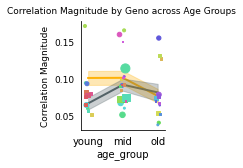

In [38]:
# Create a figure and axes for each cell_type and state
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=[1.5, 2])
emm_df = pd.read_csv('emmeans_data_JUST_AGE_CorrelationMagnitude.csv')

# Assuming emm_df is your dataframe
emm_df['age_group'] = pd.Categorical(emm_df['age_group'], categories=['young', 'mid', 'old'], ordered=True)

# data df
df = pd.read_csv('2023-08-14_meancorrelation_grouped_e4_wt.csv')

# Convert age_group to categorical and order it
df['age_group'] = pd.Categorical(df['age_group'], categories=['young', 'mid', 'old'], ordered=True)


# Define color palette for geno categories
palette = {'te4': '#FEB209', 'wt': '#536267', '.': 'gray'}  # Include '.' for missing key

# Calculate the animal-level means
animal_means = df.groupby(['animal', 'age_group', 'genotype'])['mean_correlation'].mean().reset_index()

# Define a color palette for the animals
animals = animal_means['animal'].unique()
animal_palette = dict(zip(animals, sns.color_palette("hls", len(animals))))


# Define markers for genotypes
marker = {'te4': 'o', 'wt': 's', '.': '.'}  # Include '.' for missing key

# Calculate the animal-level means and count of contributing rows
animal_means = df.groupby(['animal', 'age_group', 'genotype' ])['mean_correlation'].agg(['mean', 'count']).reset_index()
animal_means.rename(columns={'mean': 'mean_correlation', 'count': 'count'}, inplace=True)

animal_means = animal_means.dropna()

# Create the emm lineplot
sns.lineplot(x="age_group", y="emmean", hue="genotype", data=emm_df, ax=axs, palette=palette, lw=2, zorder = 1)


emm_data = emm_df
# Add shaded emm error region
for geno in emm_data["genotype"].unique():
    subset = emm_data[emm_data["genotype"] == geno].sort_values(by="age_group")
    x_coords = subset["age_group"].cat.codes
    axs.fill_between(x_coords, subset["emmean"] - subset["SE"], subset["emmean"] + subset["SE"], color=palette[geno], alpha=0.3, zorder = 1)

# Select animal-level mean data for this cell_type and state
animal_data = animal_means

# Add a small amount of random noise to x values for jitter
jitter = 0.1  # Adjust this value to control the amount of jitter
x_jitter = animal_data['age_group'].cat.codes + np.random.uniform(-jitter, jitter, size=len(animal_data))

# Create scatterplot of animal-level means with jitter and different markers for genotypes
for geno, group in animal_data.groupby('genotype'):
    axs.scatter(x=x_jitter[group.index], y=group["mean_correlation"], c=group['animal'].map(animal_palette), 
               marker=marker[geno], s=group['count']*.003, label=geno)  # Multiply 'count' by a scalar to get the right size

# Add y-axis tick labels to the left column
axs.set_ylabel('Correlation Magnitude', fontsize=9)
plt.yticks(fontsize=9
          )
# Remove the legend
axs.legend_.remove()

axs.tick_params(bottom=False, left=False)

# Add super title for the whole figure
plt.suptitle('Correlation Magnitude by Geno across Age Groups', fontsize=9)

# # Adjust layout with reduced padding between subplots
# plt.tight_layout(rect=[0, 0, 0.92, 1], w_pad=0.1, h_pad=0.1)

sns.despine()

if SAVEFIGS:
    fig.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig3.5_figures/emmeans_scatter_JUST_AGE_CorrelationMagnitude.pdf')

# Display the plot
plt.show()


# Correlation Entropy:

In [24]:
pd.read_csv('/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-14_meancorrelation_grouped_e4_wt.csv')


,Unnamed: 0,age,mean_correlation,entropy,L1_distance,animal,genotype,bin,age_group
0,1503,89.574225,0.114394,3.718793,3.889934,caf49,te4,"(0, 91]",young
1,18281,168.693947,0.155489,3.829301,2.146083,caf49,te4,"(91, 274]",mid
2,18280,168.690475,0.160414,3.830921,2.632675,caf49,te4,"(91, 274]",mid
3,18279,168.687002,0.164102,3.828009,3.667283,caf49,te4,"(91, 274]",mid
4,18278,168.683530,0.168324,3.839437,3.285069,caf49,te4,"(91, 274]",mid
...,...,...,...,...,...,...,...,...,...
198205,613,209.608067,0.073316,3.103424,0.929871,caf42,wt,"(91, 274]",mid
198206,612,209.604595,0.069091,3.054597,0.790579,caf42,wt,"(91, 274]",mid
198207,611,209.601123,0.073197,3.126153,0.801945,caf42,wt,"(91, 274]",mid
198208,624,209.646262,0.073617,3.099850,0.917309,caf42,wt,"(91, 274]",mid


In [25]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [26]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-14_meancorrelation_grouped_e4_wt.csv'
corr_data <- read_csv(file = fn)

#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
corr_lmer = lmer(entropy ~ age_group * genotype  + (1|animal), data = corr_data)


New names:
• `` -> `...1`
Rows: 198210 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): animal, genotype, bin, age_group
dbl (5): ...1, age, mean_correlation, entropy, L1_distance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [27]:
%%R
# Compute the estimated marginal means
emm <- emmeans(corr_lmer,  ~ age_group * genotype)

emm_df <- as.data.frame(emm)
# Keep only relevant columns
emm_df <- emm_df[, c("genotype", "age_group", "emmean", "SE")]

# Pairwise comparisons
contrast_results <- pairs(emm)

# Adjust for multiple comparisons
contrast_results_adjusted <- summary(contrast_results, adjust = "bonferroni")

# Display the results
print(contrast_results_adjusted)

# make a dataframe and write it to a csv for loading in python
emm_df <- as.data.frame(emm)
# Keep only relevant columns
emm_df <- emm_df[, c("genotype", "age_group", "emmean", "SE")]
write.csv(emm_df, "emmeans_data_JUST_AGE_CorrelationEntropy.csv", row.names = FALSE)


 contrast              estimate      SE  df z.ratio p.value
 mid te4 - old te4     0.288641 0.00638 Inf  45.275  <.0001
 mid te4 - young te4  -0.008234 0.00237 Inf  -3.476  0.0076
 mid te4 - mid wt      0.115637 0.09556 Inf   1.210  1.0000
 mid te4 - old wt      0.116636 0.11418 Inf   1.022  1.0000
 mid te4 - young wt    0.293040 0.09559 Inf   3.066  0.0326
 old te4 - young te4  -0.296875 0.00680 Inf -43.654  <.0001
 old te4 - mid wt     -0.173004 0.09560 Inf  -1.810  1.0000
 old te4 - old wt     -0.172005 0.11421 Inf  -1.506  1.0000
 old te4 - young wt    0.004399 0.09563 Inf   0.046  1.0000
 young te4 - mid wt    0.123871 0.09558 Inf   1.296  1.0000
 young te4 - old wt    0.124870 0.11419 Inf   1.094  1.0000
 young te4 - young wt  0.301274 0.09561 Inf   3.151  0.0244
 mid wt - old wt       0.000999 0.10831 Inf   0.009  1.0000
 mid wt - young wt     0.177404 0.00456 Inf  38.919  <.0001
 old wt - young wt     0.176404 0.10834 Inf   1.628  1.0000

Degrees-of-freedom method: asymptotic 


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 198210' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 198210' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 198210)' or larger];
but be warned that this may result in large computation time and memory use.


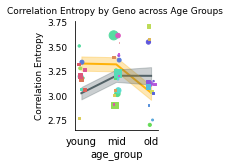

In [37]:
# Create a figure and axes for each cell_type and state
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=[1.5, 2])
emm_df = pd.read_csv('emmeans_data_JUST_AGE_CorrelationEntropy.csv')

# Assuming emm_df is your dataframe
emm_df['age_group'] = pd.Categorical(emm_df['age_group'], categories=['young', 'mid', 'old'], ordered=True)

# data df
df = pd.read_csv('2023-08-14_meancorrelation_grouped_e4_wt.csv')

# Convert age_group to categorical and order it
df['age_group'] = pd.Categorical(df['age_group'], categories=['young', 'mid', 'old'], ordered=True)


# Define color palette for geno categories
palette = {'te4': '#FEB209', 'wt': '#536267', '.': 'gray'}  # Include '.' for missing key

# Calculate the animal-level means
animal_means = df.groupby(['animal', 'age_group', 'genotype'])['entropy'].mean().reset_index()

# Define a color palette for the animals
animals = animal_means['animal'].unique()
animal_palette = dict(zip(animals, sns.color_palette("hls", len(animals))))


# Define markers for genotypes
marker = {'te4': 'o', 'wt': 's', '.': '.'}  # Include '.' for missing key

# Calculate the animal-level means and count of contributing rows
animal_means = df.groupby(['animal', 'age_group', 'genotype' ])['entropy'].agg(['mean', 'count']).reset_index()
animal_means.rename(columns={'mean': 'entropy', 'count': 'count'}, inplace=True)

animal_means = animal_means.dropna()

# Create the emm lineplot
sns.lineplot(x="age_group", y="emmean", hue="genotype", data=emm_df, ax=axs, palette=palette, lw=2, zorder = 1)


emm_data = emm_df
# Add shaded emm error region
for geno in emm_data["genotype"].unique():
    subset = emm_data[emm_data["genotype"] == geno].sort_values(by="age_group")
    x_coords = subset["age_group"].cat.codes
    axs.fill_between(x_coords, subset["emmean"] - subset["SE"], subset["emmean"] + subset["SE"], color=palette[geno], alpha=0.3, zorder = 1)

# Select animal-level mean data for this cell_type and state
animal_data = animal_means

# Add a small amount of random noise to x values for jitter
jitter = 0.1  # Adjust this value to control the amount of jitter
x_jitter = animal_data['age_group'].cat.codes + np.random.uniform(-jitter, jitter, size=len(animal_data))

# Create scatterplot of animal-level means with jitter and different markers for genotypes
for geno, group in animal_data.groupby('genotype'):
    axs.scatter(x=x_jitter[group.index], y=group["entropy"], c=group['animal'].map(animal_palette), 
               marker=marker[geno], s=group['count']*.003, label=geno)  # Multiply 'count' by a scalar to get the right size

# Add y-axis tick labels to the left column
axs.set_ylabel('Correlation Entropy', fontsize=9)
plt.yticks(fontsize=9
          )
# Remove the legend
axs.legend_.remove()

axs.tick_params(bottom=False, left=False)

# Add super title for the whole figure
plt.suptitle('Correlation Entropy by Geno across Age Groups', fontsize=9)

# # Adjust layout with reduced padding between subplots
# plt.tight_layout(rect=[0, 0, 0.92, 1], w_pad=0.1, h_pad=0.1)

sns.despine()

if SAVEFIGS:
    fig.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig3.5_figures/emmeans_scatter_JUST_AGE_CorrelationEntropy.pdf')

# Display the plot
plt.show()


In [39]:
SAVEFIGS = 0
